In [ ]:
# ## install finrl library
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/flpymonkey/FinRL_Online_Portfolio_Benchmarks.git

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.env_stock_trading.env_stocktrading_nocash import StockTradingEnvNoCash
from finrl.agents.stablebaselines3.models_weighted import DRLEnsembleAgentWeighted

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

c:\USERS\BENCJ\DESKTOP\ECON4\THESIS\.VENV\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [3]:
# TODO, remove DOW from training as it is missing some values in 2019
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [4]:
TRAIN_START_DATE = '2009-04-01'
TRAIN_END_DATE = '2021-01-01'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-06-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import DOW_30_TICKER


# TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (96135, 8)


In [5]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [6]:
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

# here you can see the engineered features are added to each stock day
print(processed)


Successfully added technical indicators
Successfully added turbulence index
             date        open        high  ...     cci_30       dx_30  turbulence
0      2009-04-01    3.717500    3.892857  ...  66.666667  100.000000     0.00000
1      2009-04-01   48.779999   48.930000  ...  66.666667  100.000000     0.00000
2      2009-04-01   13.340000   14.640000  ...  66.666667  100.000000     0.00000
3      2009-04-01   34.520000   35.599998  ...  66.666667  100.000000     0.00000
4      2009-04-01   27.500000   29.520000  ...  66.666667  100.000000     0.00000
...           ...         ...         ...  ...        ...         ...         ...
96130  2022-05-31  503.619995  504.109985  ... -15.116925   16.342870    33.82767
96131  2022-05-31  210.380005  214.350006  ...  56.314435   13.501659    33.82767
96132  2022-05-31   51.259998   51.560001  ...  66.494865    3.544938    33.82767
96133  2022-05-31   43.480000   44.270000  ...  10.608040    7.879621    33.82767
96134  2022-05-31   42

In [7]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [8]:
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS, # TODO we pass these in and set the environment
    "action_space": stock_dimension, # TODO we define the action space shape as the number of stock tickers
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

# buy_cost_list = sell_cost_list = [0.001] * stock_dimension
# num_stock_shares = [0] * stock_dimension
# env_kwargs = {
#     "hmax": 100,
#     "initial_amount": 1000000,
#     "num_stock_shares": num_stock_shares,
#     "buy_cost_pct": buy_cost_list,
#     "sell_cost_pct": sell_cost_list,
#     "state_space": state_space,
#     "stock_dim": stock_dimension,
#     "tech_indicator_list": INDICATORS,
#     "action_space": stock_dimension,
#     "reward_scaling": 1e-4
# }

In [9]:
rebalance_window = 63 # rebalance_window is the number of days to retrain the model
validation_window = 63 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

# TODO here we pass in the engineered features along with the stock data
ensemble_agent = DRLEnsembleAgentWeighted(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)
# e_train_gym = StockTradingEnv(df = processed, **env_kwargs)
# agent = DRLAgent(e_train_gym)
# if_using_a2c = True
# model_a2c = agent.get_model("a2c")
# # if if_using_a2c:
# #   tmp_path = RESULTS_DIR + '/a2c'
# #   new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
# #   model_a2c.set_logger(new_logger_a2c)
# trained_a2c = agent.train_model(model=model_a2c,
#                              tb_log_name='a2c',
#                              total_timesteps=50000)

In [20]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 100000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 100, "buffer_size": 1000000, "learning_rate": 0.0001}




# timesteps_dict = {'a2c' : 10_000,
#                  'ppo' : 10_000,
#                  'ddpg' : 10_000,
#                  'sac' : 10_000,
#                  'td3' : 10_000
#                  }

timesteps_dict = {
                
                 'ppo' : 10_000,
                 }

In [21]:
# # Uncomment this to actually train a new model
df_summary = ensemble_agent.run_ensemble_strategy(None,
                                                 PPO_model_kwargs,
                                                 None,
                                                 None,
                                                 None,
                                                 timesteps_dict)

df_summary

============Start Ensemble Strategy============
turbulence_threshold:  203.40185729744655
======Model training from:  2009-04-01 to  2021-01-04
======ppo Training========
{'ent_coef': 0.01, 'n_steps': 2048, 'learning_rate': 0.00025, 'batch_size': 128}
Using cpu device
Logging to tensorboard_log/ppo\ppo_126_24
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner Error: 'reward'
Original Error: 'obs'
Inner E

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2021-01-04,2021-04-06,PPO,None,0.442885,None,None,None
1,189,2021-04-06,2021-07-06,PPO,None,0.122393,None,None,None
2,252,2021-07-06,2021-10-04,PPO,None,-0.142305,None,None,None
3,315,2021-10-04,2022-01-03,PPO,None,0.109556,None,None,None


In [22]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [23]:
import pandas as pd

# Assuming these variables are already defined
# unique_trade_date, rebalance_window, validation_window

# Create DataFrame for trade dates
df_trade_date = pd.DataFrame({'datadate': unique_trade_date})

# Initialize an empty DataFrame for account values
df_account_value = pd.DataFrame()

# Read and concatenate CSV files
for i in range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble', i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)

# Calculate Sharpe Ratio

# TODO is this a valid way to calculate sharpe ratio???????????????????????????????????????????????????????
sharpe = (252 ** 0.5) * df_account_value.account_value.pct_change(1).mean() / df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio:', sharpe)

# Join DataFrames
df_account_value = df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))


Sharpe Ratio: -0.0328914145793834


In [24]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1.000000e+06,2021-04-06,NaN,2021-04-06
1,9.999998e+05,2021-04-07,-2.341453e-07,2021-04-07
2,1.000008e+06,2021-04-08,7.870517e-06,2021-04-08
3,1.000040e+06,2021-04-09,3.189240e-05,2021-04-09
4,1.000025e+06,2021-04-12,-1.475662e-05,2021-04-12


<Axes: >

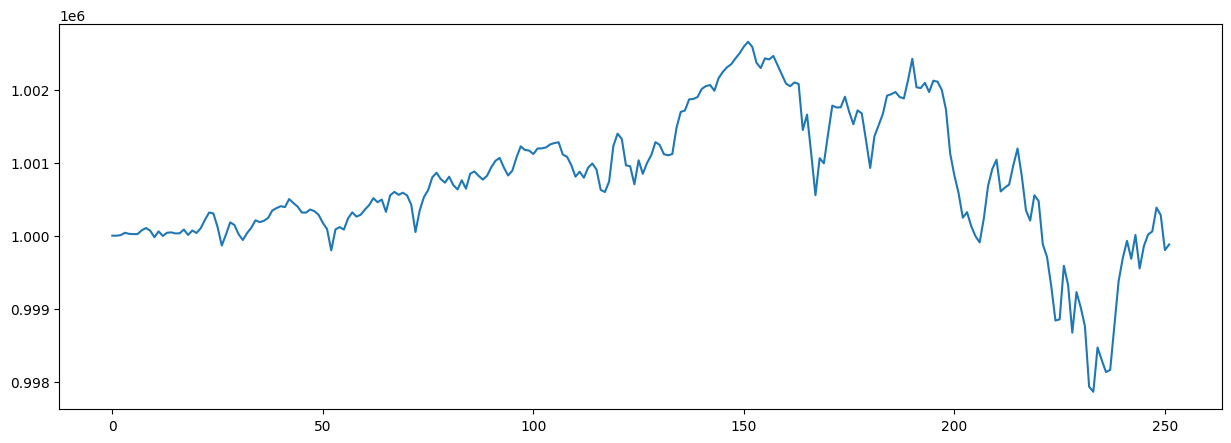

In [25]:
%matplotlib inline
df_account_value.account_value.plot()

In [26]:


print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return         -0.000121
Cumulative returns    -0.000121
Annual volatility      0.003513
Sharpe ratio          -0.032891
Calmar ratio          -0.025358
Stability              0.004696
Max drawdown          -0.004780
Omega ratio            0.994066
Sortino ratio         -0.044987
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.862537
Daily value at risk   -0.000443
dtype: float64


In [27]:
#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (251, 8)
Annual return          0.037486
Cumulative returns     0.037335
Annual volatility      0.134331
Sharpe ratio           0.342028
Calmar ratio           0.331049
Stability              0.066383
Max drawdown          -0.113235
Omega ratio            1.058031
Sortino ratio          0.480831
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970301
Daily value at risk   -0.016742
dtype: float64


In [35]:
df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji+.csv")

df_account_value.to_csv('df_account_value.csv')

df_dji:             date           dji
0    2021-04-06  1.000000e+06
1    2021-04-07  1.000479e+06
2    2021-04-08  1.002194e+06
3    2021-04-09  1.011079e+06
4    2021-04-12  1.009427e+06
..          ...           ...
247  2022-03-28  1.045637e+06
248  2022-03-29  1.055757e+06
249  2022-03-30  1.053801e+06
250  2022-03-31  1.037335e+06
251  2022-04-01           NaN

[252 rows x 2 columns]
df_dji:                       dji
date                    
2021-04-06  1.000000e+06
2021-04-07  1.000479e+06
2021-04-08  1.002194e+06
2021-04-09  1.011079e+06
2021-04-12  1.009427e+06
...                  ...
2022-03-28  1.045637e+06
2022-03-29  1.055757e+06
2022-03-30  1.053801e+06
2022-03-31  1.037335e+06
2022-04-01           NaN

[252 rows x 1 columns]


            ensemble
date                
2021-04-06  1.000000
2021-04-07  1.000000
2021-04-08  1.000008
2021-04-09  1.000040
2021-04-12  1.000025
...              ...
2022-03-28  1.000058
2022-03-29  1.000384
2022-03-30  1.000283
2022-03-31  0.999802
2022-04-01  0.999879

[252 rows x 1 columns]
df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_trade_date:         datadate
0    2021-01-04
1    2021-01-05
2    2021-01-06
3    2021-01-07
4    2021-01-08
..          ...
350  2022-05-24
351  2022-05-25
352  2022-05-26
353  2022-05-27
354  2022-05-31

[355 rows x 1 columns]
df_result_ensemble:              ensemble
date                
2021-04-06  1.000000
2021-04-07  1.000000
2021-04-08  1.000008
2021-04-09  1.000040
2021-04-12  1.000025
...              ...
2022-03-28  1.000058
2022-03-29  1.000384
2022-03-30  1.000283
2022-03-31  0.999802
2022-04-01  0.999879

[252 rows x 1 columns]
==============Compare to DJIA===========
result:              ensemble       dji
date   

C:\Users\bencj\AppData\Local\Temp\ipykernel_10468\1358670689.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_result_ensemble['ensemble'].fillna(0, inplace=True)
C:\Users\bencj\AppData\Local\Temp\ipykernel_10468\1358670689.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.


<Figure size 1500x500 with 0 Axes>

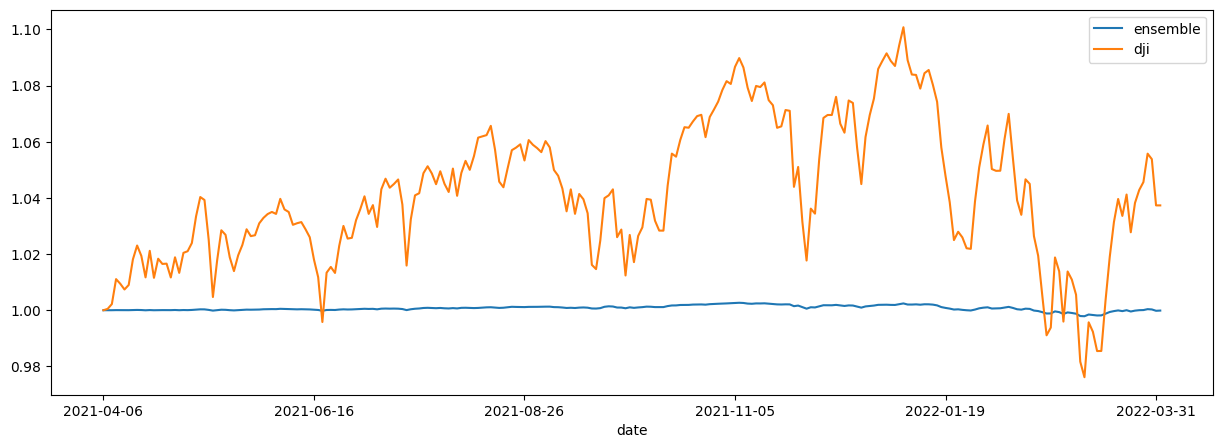

In [53]:
# print("==============Compare to DJIA===========")
# %matplotlib inline
# # S&P 500: ^GSPC
# # Dow Jones Index: ^DJI
# # NASDAQ 100: ^NDX
# backtest_plot(df_account_value,
#               baseline_ticker = '^DJI',
#               baseline_start = df_account_value.loc[0,'date'],
#               baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])
df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})


# df_result_ensemble['ensemble'] = df_result_ensemble['ensemble'] * 100
df_result_ensemble = df_result_ensemble.set_index('date')

df_result_ensemble['ensemble'] = df_result_ensemble['ensemble'].pct_change()
df_result_ensemble['ensemble'].fillna(0, inplace=True)
df_result_ensemble['ensemble'] = (1 + df_result_ensemble['ensemble']).cumprod()

print(df_result_ensemble)

print("df_result_ensemble.columns: ", df_result_ensemble.columns)

# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
df_result_ensemble.to_csv("df_result_ensemble.csv")
print("df_result_ensemble: ", df_result_ensemble)
print("==============Compare to DJIA===========")
result = pd.DataFrame()
# result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result = pd.merge(result, df_dji, left_index=True, right_index=True)


df_dji['dji'] = df_dji['dji'].pct_change()
df_dji['dji'].fillna(0, inplace=True)
df_dji['dji'] = (1 + df_dji['dji']).cumprod()


result = pd.merge(df_result_ensemble, df_dji, left_index=True, right_index=True)
print("result: ", result)
result.to_csv("result.csv")
result.columns = ['ensemble', 'dji']

print(result)

%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();